In [1]:
import re, string,os
from glob import glob as gb
import pandas as pd
from tqdm import tqdm
from collections import Counter
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib
from functions import *
import calendar
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime
import matplotlib.dates as mdates
import nltk

from nltk.corpus import stopwords

base_path = "/home/ruben/Documents/GitHub/ParlaMintCase"

In [2]:
tf = pd.read_csv(base_path + '/resources/keywords-corona-translation.csv')
tf_corona = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}

tf = pd.read_csv(base_path + '/resources/keywords-expertise-translation.csv')
tf_science = {language:dict(zip(tf[tf['language'] == language]['word'],tf[tf['language'] == language]['translation'])) for language in list(set(tf['language']))}
tf_science = {k:{x:i for x,i in v.items() if x not in ["policy","program","measures"]} for k,v in tf_science.items()}

In [18]:
def load(iso,language,sample=True,sample_unit='month'):
    # Custom dataloader function, finds only nouns and subsets covid + expertise speeches
    df = data_loader.load_month(iso,'2020-02','2020-06')
    df = df[df['text'].notna()]
    df = df.drop_duplicates().reset_index(drop=True)
    stopwords_ = nltk.corpus.stopwords.words(language)
    df['text'] = [[w for w in str(t).split(' ') if "_" in w and len(w.split('_')) != 1] for t in df['posner']]
    df['text'] = [" ".join([w.split('_')[0] for w in text if w.split('_')[1] in ['NOUN']]) for text in df['text']]
    df['text'] = [utils.preprocess(str(x),stopwords_) for x in tqdm(df['text'])]
    df = df[df['text'].astype(str).str.contains("|".join(list(tf_science[iso].values())))].reset_index(drop=True)
    df = df[df['text'].astype(str).str.contains("|".join(list(tf_corona[iso].values())))].reset_index(drop=True)
    df = df.drop(['lemmatized','posner','title'],axis=1)
    df['month'] = [x[:7] for x in df['from']]
    df['week'] = [df['from'][c][:4] + '-' + str(datetime.strptime(x, '%Y-%m-%d').isocalendar()[1]) for c,x in enumerate(df['from'])]
    df['week'] = [x.replace('-','-0') if len(x) == 6 else x for x in df['week']]
    print('length data',len(df))
    df = df.rename(columns={"from":"day"})

    if sample==True:
        df = df.groupby(sample_unit).sample(20,replace=True).drop_duplicates().reset_index()
    return df

In [30]:
# Top Terms

def get_top_terms(df,date_format='week',topn=15):
    df = df.groupby([date_format]).agg({"text": lambda x: " ".join(x)}).reset_index()

    r = pd.DataFrame()
    tfidf_obj,docterms = tfidf.get_docterms(df,'text')
    for day in sorted(list(set(df[date_format]))):
        df['dl'] = ["day" if date_ == day else "other" for date_ in df[date_format]]
        tftw = tfidf.get_topterms(tfidf_obj,docterms,df,'dl')
        r[day] = tftw['day'][:topn]

    dates = sorted(list(r.columns))
    names = ["\n".join(list(r[d][:10])) for d in dates]
    if date_format == 'day':
        dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
    if date_format == 'week':
        dates = [datetime.strptime(d + "-1", "%Y-%W-%w") for d in dates]
    if date_format == 'month':
        dates = [datetime.strptime(d, "%Y-%m") for d in dates]
    return r,names,dates

In [31]:
# Styling
plotting.style_()
sns.set_style("white")

def plot_(rdf,names,dates,width=20,height=5,fname='filename'):
    levels = np.tile([-28, 10, 3, -5, 8, -15, 13, -5, 5],int(np.ceil(len(dates)/8)))[:len(dates)]

    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=(width, height), constrained_layout=False)

    ax.vlines(dates, 0, levels, color="tab:red",alpha=0.35)  # The vertical stems.
    ax.plot(dates, np.zeros_like(dates), "-o",color="k", markerfacecolor="black",markersize=5)  # Baseline and markers on it.

    # annotate lines
    for d, l, r in zip(dates, levels, names):
        ax.annotate(r, xy=(d, l),
                    xytext=(-3, np.sign(l)*3), textcoords="offset points",
                    horizontalalignment="right",
                    verticalalignment="bottom" if l > 0 else "top",
                    fontsize=7)

    # format xaxis with 4 month intervals
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right",fontsize=24)

    # remove y axis and spines
    ax.yaxis.set_visible(False)
    # ax.spines[["left", "top", "right"]].set_visible(False)

    ax.margins(0.05)
    plt.ylim(-40,30)
    sns.despine(bottom = True, left = True,top = True, right = True)
    plt.savefig(fname,dpi=250,bbox_inches='tight')
    plt.show()

In [48]:
df = load('it','italian',sample=False,sample_unit='day')

100%|██████████| 1865/1865 [00:01<00:00, 1575.38it/s]length data 141



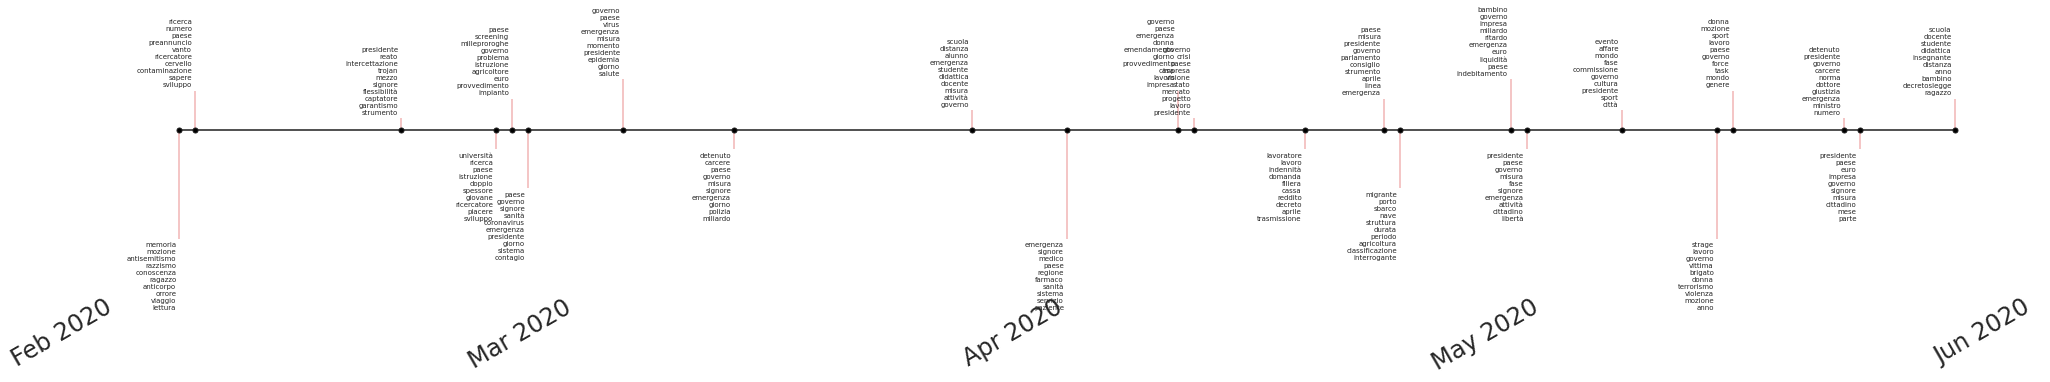

In [49]:
rdf,names,dates = get_top_terms(df,date_format='day',topn=10)
plot_(rdf,names,dates,35,5,f'/home/ruben/Documents/GitHub/ParlaMintCase/results/plots/tfidf/tfidf-it-topterms-sampled-day.png')